# Generating LHC data with GANs

Here, we learn using Generative Adverserial Networks (GANs) to generate LHC data.

Background:
- Simulations for LHC physics is a major computational task at the experiment, and will become more computationally intensive in the coming years, so if ML techniques can speed up some aspects of this then it would be very useful
- As a proof of concept, we will show how a GAN can be optimized to generate events simulated by traditional high energy physics simulation software
- The process we are studying is Drell-Yan: $pp\rightarrow Z\rightarrow \mu\mu$
- Naively, the dimension of this phase space is 8D, the 4 momentum of the two final state particles
- A GAN consists of a generative network and an adverserial network, trained through a min-max optimisation procedure
- The generative network samples random noise from a unit Normal distribution, passes it through a dense fully connected network to produce an 8D output
- The adverserial network then tries to classify between the generated data and the real data, and the generator is trained such that this adverserial network cannot classify between the generated data and the discriminator

Interesting papers:
- Generative Adverserial Networks
    - Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio
    - https://arxiv.org/abs/1406.2661
- How to GAN LHC events
    - Anja Butter, Tilman Plehn, Ramon Winterhalder
    - https://arxiv.org/abs/1907.03764
- How to GAN : Novel simulation methods for the LHC
    - Ramon Winterhalder
    - PhD thesis: https://inspirehep.net/literature/1839755

Outline:
- Imports and plotting set-up
- Study the data
- Datasets and dataloaders
- Building the GAN
- Optimising the GAN
- Study the results - let's generate some events!
- Removing redundant degrees of freedom
- Optimising the GAN on the reduced data
- Study the new results
- Concluding remarks

Some tips:
- GANs can require some thought in optimising them
- They need regularisation
- This is due to the min-max nature of the loss function
    - improving the generative network leads to a worsening of the classifier
- Most practical pytorch skills you need for this work is covered in the basics tutorial at https://pytorch.org/tutorials/beginner/basics/intro.html.

## Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU
from torch.nn.utils import spectral_norm

### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

# global plotting settings
FONTSIZE = 18

# matplotlib settings
plt.show()
plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}")
plt.rc("text", usetex=True)

# colors
colors = [f"C{i}" for i in range(5)]

In [ ]:
# global plotting settings
FONTSIZE = 18

# matplotlib settings
plt.show()
plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}")
plt.rc("text", usetex=True)

# colors
colors = [f"C{i}" for i in range(5)]

## Loading the data

We can load the data from here:

In [3]:
dy_trn_data = np.load( 'datasets/tutorial-2-data/dy_trn_data.npy' )
dy_val_data = np.load( 'datasets/tutorial-2-data/dy_val_data.npy' )
dy_tst_data = np.load( 'datasets/tutorial-2-data/dy_tst_data.npy' )

In [4]:
dy_trn_data.shape, dy_val_data.shape, dy_tst_data.shape

((1384081, 8), (296588, 8), (296588, 8))

Each element of the data has 8 entries, corresponding to the 4-momenta of each muon in the process.

Each entry has the form $[E_1, p_{x,1}, p_{y,1}, p_{z,1}, E_2, p_{x,2}, p_{y,2}, p_{z,2}]$.

## Study the data

We need to be able to calculate the invariant mass of each event, and the $p_T$ of the event and the jets.

Let's write a function for this:

In [340]:
def get_obs( event ):
    
    jet1_4m = event[:,0:4]
    jet2_4m = event[:,4:]
    evnt_4m = np.sum( (jet1_4m,jet2_4m), axis=0 )
    
    evnt_im = np.sqrt( np.sum( ( evnt_4m[:,0]**2, -evnt_4m[:,1]**2, -evnt_4m[:,2]**2, -evnt_4m[:,3]**2 ), axis=0 ) )
    
    evnt_pt = np.sqrt( evnt_4m[:,1]**2 + evnt_4m[:,2]**2 )
    jet1_pt = np.sqrt( jet1_4m[:,1]**2 + jet1_4m[:,2]**2 )
    jet2_pt = np.sqrt( jet2_4m[:,1]**2 + jet2_4m[:,2]**2 )
    
    return evnt_im, evnt_pt, jet1_pt, jet2_pt

Now test it:

In [6]:
get_obs( dy_trn_data[0:2] )

(array([90.98955316, 91.3711254 ]),
 array([0., 0.]),
 array([44.32344982, 35.10745113]),
 array([44.32344982, 35.10745113]))

The $p_T$ of the events will always be zero here due to the fact that the initial incoming protons have no transverse momentum.

Let's get the observables for the whole dataset:

In [7]:
trn_evnt_ims, trn_evnt_pts, trn_jet1_pts, trn_jet2_pts = get_obs( dy_trn_data )
val_evnt_ims, val_evnt_pts, val_jet1_pts, val_jet2_pts = get_obs( dy_val_data )
tst_evnt_ims, tst_evnt_pts, tst_jet1_pts, tst_jet2_pts = get_obs( dy_tst_data )

In [328]:
trn_evnt_ims.shape

(1384081,)

Let's plot the invariant mass of the events:

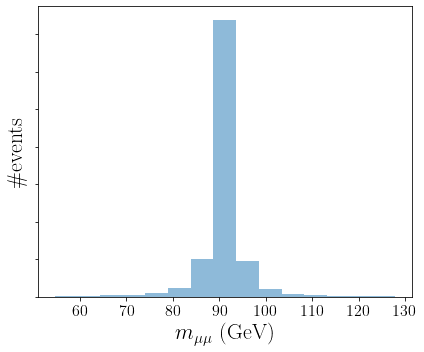

In [9]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( trn_evnt_ims, alpha=0.5, density=True, bins=15 )

axs.set_xlabel( "$m_{\mu\mu}$ [GeV]")
axs.set_ylabel( "\#events")

yticks = [  ]
axs.set_yticklabels( yticks)

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks)

fig.tight_layout()
fig.show()

Here we see the clear $Z$ mass peak at $\simeq 90$ GeV.

Now let's look at $p_T$ distributions:

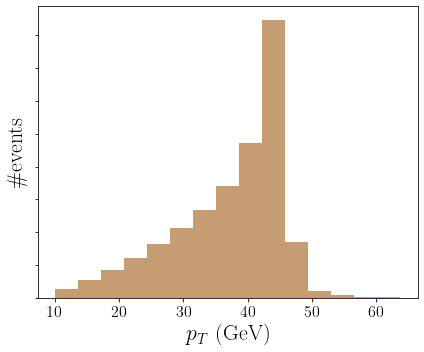

In [10]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( trn_jet1_pts, alpha=0.5, density=True, bins=15 )
axs.hist( trn_jet2_pts, alpha=0.5, density=True, bins=15 )

axs.set_xlabel( "$p_\text{T}$ [GeV]")
axs.set_ylabel( "\#events")

yticks = [  ]
axs.set_yticklabels(yticks)

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks)

fig.tight_layout()
fig.show()

These distributions are completely overlapping with a peak near $m_{\mu\mu}/2$.

## Datasets and dataloaders

This time we only need the dataloader to return the data, no labels, so it's pretty simple.

In [11]:
class drell_yan_data( Dataset ):
    
    def __init__( self, data ):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

Let's normalise the data a little bit by dividing all dimensionful quantities by $100$ GeV.

In [12]:
dy_trn_data_p = torch.Tensor( dy_trn_data / 100 )
dy_val_data_p = torch.Tensor( dy_val_data / 100 )
dy_tst_data_p = torch.Tensor( dy_tst_data / 100 )

In [13]:
trn_dataset = drell_yan_data( dy_trn_data_p )
val_dataset = drell_yan_data( dy_val_data_p )
tst_dataset = drell_yan_data( dy_tst_data_p )

Using a bigger batch size this time, this helps for generative networks.

In [14]:
trn_dataloader = DataLoader( trn_dataset, batch_size=2500, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=2500, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=2500, shuffle=True )

## Building the GAN

We need two networks, a generative network and an adverserial network:

In [ ]:
# TODO

## Optimizing the GAN

We need two loss functions, one for the generative part and one for the adverserial.

The adverserial net is just a classifier, so it's loss is simple, binary cross entropy.

For the generative network we can also use the binary cross entropy, where the labels for the generated and true data are:
- 0 for generated data
- 1 for true data

For the loss function we use the BCEWithLogitsLoss loss function.

This passes the input through a sigmoid before putting it into the BCE loss.  The logarithms from the BCE and the exponentials in the sigmoids are then treated in more numerically stable way.

To get the correct loss function for updates of the generative network, we are required to compute the loss using fake data and the real labels.

Lastly, we of course now need to pass the models, optimisers, and schedulers for both networks to the train_epoch function.

Check it out here:  https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

In [18]:
loss_fn = nn.BCEWithLogitsLoss()

In [332]:
#TODO: define training of one epoch

To optimize the network we need separate optimizers for each model, and we also add a learning rate scheduler regulate the training further.

In [ ]:
#TODO: write training loop

## Study the results

First let's plot the training and validation losses to see how they look.

In [ ]:
#TODO

## Let's generate some events!

We first need to generate random data from the unit normal distribution, the same used during training, with the correct shape.  Here we use 10k samples.

TODOs:
1. Plot the energy distribution of the first jet, for both real and generated data
2. Do the same for $p_y$ of the first jet
3. Check $p_T$ of first jet
4. Check the invariant mass of $\mu\mu$

## Concluding remarks

What can we try to improve?